## Analysis of datasets + stats for compressing with FPDE
This notebook contains methods for passing a .shp-file (or directory) and obtaining stats for the FPDE properties of the compression. Stats include the number of chunks, number of deltas within each chunk, average number of vertices, and a distribution of the overhead within the format.

## Evaluating one shape-file
The methods take one .shp-file and return the stats. Multiple calls can be merged further done if a set of .shp-files are to be analysed.

In [1]:
import jsonlines
import glob
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import tqdm
import shapely
import random
import os
from shapely.wkt import loads
from algos.fpd_extended_lib.cfg import *
import numpy as np
import re
import seaborn as sns
from algos.alg_fpd_extended import FpdExtended

In [2]:
#df = gpd.read_file('data/ne_10m_admin_1_states_provinces.shp')
#df = gpd.read_file('data/sweden-latest-free/gis_osm_buildings_a_free_1.shp')
#df = gpd.read_file('data/sweden-latest-free/gis_osm_natural_a_free_1.shp')
MAX_ITER = 100000

def load_shp(file_name, DO_VERTEX_CNT, accumulative=False):
    df = gpd.read_file(file_name)
    print("Count of entries:", len(df))
    df = df[df.type != "Point"]
    print("---", file_name, "---")
    print("Count of entries (no points):", len(df))
    if len(df) == 0:
        return pd.DataFrame(), []
    shapes = df.geometry
    if MAX_ITER != -1 and not accumulative:
        shapes = shapes.sample(n=MAX_ITER, replace=True)

    vertex_cnt = []
    if DO_VERTEX_CNT:
        for s in tqdm.tqdm(shapes):
            vertex_cnt.append(shapely.get_num_coordinates(s))

        vertex_cnt = np.array(vertex_cnt)
        if len(vertex_cnt) != 0:
            res = f"Total: {len(vertex_cnt)}, avg: {round(np.average(vertex_cnt), 2)}, std: {round(np.std(vertex_cnt), 2)}, median: {np.median(vertex_cnt)}, min: {np.min(vertex_cnt)}, max: {np.max(vertex_cnt)}, #>=25: {(vertex_cnt >= 25).sum()} ({round(100 * (vertex_cnt >= 25).sum() / len(vertex_cnt), 2)}), #>=100: {(vertex_cnt >= 100).sum()} ({round(100 * (vertex_cnt >= 100).sum() / len(vertex_cnt), 2)}), #>=200: {(vertex_cnt >= 200).sum()} ({round(100 * (vertex_cnt >= 200).sum() / len(vertex_cnt), 2)}), #>=500: {(vertex_cnt >= 500).sum()} ({round(100 * (vertex_cnt >= 500).sum() / len(vertex_cnt), 2)}), #>=1000: {(vertex_cnt >= 1000).sum()} ({round(100 * (vertex_cnt >= 1000).sum() / len(vertex_cnt), 2)})"
            print(res)
            with open('vertex_cnt_for_datasets.txt', 'a') as f:
                f.write(f"{file_name}\n{res}\n\n")
        else:
            print("No geometries (except Point(s)) in dataset.")
    return shapes, vertex_cnt

In [3]:
from algos.fpd_extended_lib.decompress import decode_header
from algos.fpd_extended_lib import cfg

def fpde_analyze(shapes, collected_stats=None):
    stats = pd.DataFrame(columns=["No Comp Size", "Comp Size", "Comp Factor", "Delta Size", "Vertex Cnt", "Chunk Cnt", "Avg Vertices in Chk", "Std Vertices in Chk", "Median Vertices in Chk", "Min Vertices in Chk", "Max Vertices in Chk"])
    stats_distribution = pd.DataFrame()
    stats_max_values = pd.DataFrame()
    if collected_stats != None:
        stats, stats_distribution, stats_max_values = collected_stats
    alg = FpdExtended()

    for idx, s in enumerate(tqdm.tqdm(shapes)):
        bin = alg.compress(s)[1]
        wkb_len = len(shapely.to_wkb(s))
        bin_len = len(bin)
        coords_len = shapely.get_num_coordinates(s)

        chks, _, overhead_stats = alg.get_chunks(bin, include_ring_start=False, verbose=True)
        cfg.offset = 0
        d_size, geom_type = decode_header(bin)
        chk_cnt = len(chks)
        chk_lens = list(map(lambda x: len(x), chks))

        stats.loc[len(stats)] = [wkb_len, bin_len, wkb_len / bin_len, d_size, coords_len, chk_cnt, np.average(chk_lens), np.std(chk_lens), np.median(chk_lens), np.min(chk_lens), np.max(chk_lens)]

        # Analysis of space
        max_values, distrb = overhead_stats
        theoretical_size = sum(distrb.values())
        distrb = pd.DataFrame(distrb, index=[idx])
        stats_distribution = pd.concat([stats_distribution, distrb])
        stats_max_values = pd.concat([stats_max_values, pd.DataFrame(max_values, index=[idx])])

        DISPLAY_PER_SHAPE_STATS = False
        if DISPLAY_PER_SHAPE_STATS:
            display(distrb)
            print("Size (calculated, rounded to byte, real):", theoretical_size, f"({((theoretical_size + 7) & (-8))})", bin_len * 8)
            print("Max Values:", dict(max_values))

    print("---- AVERAGE COMPRESSED SHAPE ----")
    pd.set_option('display.precision', 2)
    display(stats.mean())
    print("Global: Min Vertices in Chk / Max Vertices in Chk", np.min(stats['Min Vertices in Chk']), np.max(stats['Max Vertices in Chk']))

    print("---- DATA DISTRIBUTION ----")
    final_distribution = stats_distribution.mean()
    display(final_distribution)
    normalized_distribution = final_distribution.apply(lambda x: 100 * x / sum(final_distribution))
    display(normalized_distribution)

    print("---- TO SET MANUAL PARAMS ----")
    final_max_values = stats_max_values.max()
    min_bits = final_max_values.apply(lambda x: required_bits(x))
    min_bits = min_bits.add_prefix("Bits ")
    display(pd.concat([final_max_values, min_bits]))
    return stats, stats_distribution, stats_max_values, normalized_distribution

In [4]:
DATASET = 'data/sweden-latest-free/gis_osm_railways_free_1.shp'
DATASET = 'data/sweden-latest-free'
#DATASET = 'data/sweden-latest-free/gis_osm_natural_free_1.shp'
#DATASET = "data/sweden-latest-free/gis_osm_buildings_a_free_1.shp"
#DATASET = "data/sweden-latest-free/gis_osm_roads_free_1.shp"
#DATASET = 'data/ne_10m_admin_1_states_provinces.shp'
ONLY_VERTEX_CNT = False # Can be used if only the amount of vertices in the dataset is required

if DATASET.endswith(".shp"):
    files = [DATASET]
else:
    files = glob.glob(DATASET + '/*.shp')
#files = ["data/sweden-latest-free/gis_osm_buildings_a_free_1.shp", "data/sweden-latest-free/gis_osm_roads_free_1.shp", "data/china-latest-free/gis_osm_water_a_free_1.shp", "data/final_country_borders.shp"]
#files = ["data/sweden-latest-free/gis_osm_railways_free_1.shp", "data/ne_10m_admin_1_states_provinces.shp"]
#files = ['QGIS/Report_Visualizations.shp', 'QGIS/Intersection_Tricky_Cases.shp']
#files = ["data/sweden-latest-free/gis_osm_pois_free_1.shp", "QGIS/Report_Visualizations.shp"]

legends = ["Sweden Buildings", "Sweden Roads", "China Water", "Admin Borders"]

all_vertex_cnts = []
stats = pd.DataFrame()
collected_stats = None
all_shapes = []
ACCUMULATE_STATS = False # Should separate .shp-files be merged?
ACCUMULATE_NAME = "Sweden All"

for i, f in enumerate(tqdm.tqdm(files, disable=True)):
    shapes, vertex_cnt = load_shp(f, ONLY_VERTEX_CNT or ACCUMULATE_STATS, ACCUMULATE_STATS)
    all_shapes.append(shapes)
    all_vertex_cnts.append([f, vertex_cnt])
    if not ONLY_VERTEX_CNT and not ACCUMULATE_STATS:
        stats_chunks, stats_distribution, stats_max_values, normalized_distribution = fpde_analyze(shapes)
        df = pd.DataFrame(normalized_distribution, columns=['Percent'])
        df['Dataset'] = legends[i] if not ACCUMULATE_STATS else ACCUMULATE_NAME
        stats = pd.concat([stats, df])

# Now know how to weight the sampling
if not ONLY_VERTEX_CNT and ACCUMULATE_STATS:
    for i, f in enumerate(tqdm.tqdm(files, disable=True)):
        shapes = all_shapes[i].sample(n=int(MAX_ITER * len(all_vertex_cnts[i][1]) / sum([len(cnt[1]) for cnt in all_vertex_cnts])), replace=True)
        stats_chunks, stats_distribution, stats_max_values, normalized_distribution = fpde_analyze(shapes, collected_stats)
        collected_stats = stats_chunks, stats_distribution, stats_max_values
    df = pd.DataFrame(normalized_distribution, columns=['Percent'])
    df['Dataset'] = ACCUMULATE_NAME
    stats = pd.concat([stats, df])

KeyboardInterrupt: 

In [5]:
import pickle
# with open('data/sweden_all_fpde_analysis_overhead.pkl', 'wb') as f:
#     pickle.dump(stats, f)

# with open('data/fpde_analysis_overhead.pkl', 'wb') as f:
#     pickle.dump(stats, f)

with open('data/sweden_all_fpde_analysis_overhead.pkl', 'rb') as f:
    stats_sweden = pickle.load(f)

with open('data/fpde_analysis_overhead.pkl', 'rb') as f:
    stats = pickle.load(f)

In [6]:
stats = pd.concat([stats.iloc[:16], stats_sweden, stats.iloc[16:]], axis=0)

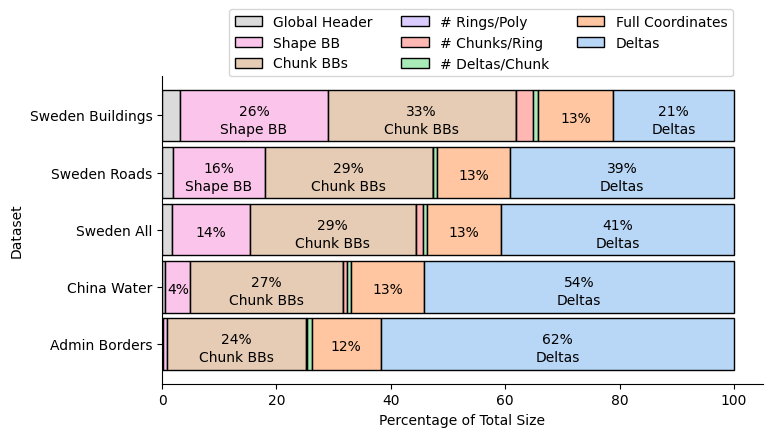

,Type,Percent,Dataset
0,Global Header,3.215654,Sweden Buildings
1,Shape BB,25.725231,Sweden Buildings
2,Chunk BBs,32.856008,Sweden Buildings
3,# Rings/Poly,0.000261,Sweden Buildings
4,# Chunks/Ring,3.020645,Sweden Buildings
5,# Deltas/Chunk,0.825772,Sweden Buildings
6,Full Coordinates,13.212350,Sweden Buildings
7,Deltas,21.144078,Sweden Buildings
8,Global Header,1.992718,Sweden Roads
9,Shape BB,15.941744,Sweden Roads


In [7]:
df = stats.reset_index()
df = df.rename(columns={'index': 'Type'})
df['Type'] = df['Type'].apply(lambda x: x[0:-8])
df['Type'] = df['Type'].replace('Poly Ring Cnt', '# Rings/Poly')
df['Type'] = df['Type'].replace('Ring Chk Cnt', '# Chunks/Ring')
df['Type'] = df['Type'].replace('Chk Deltas Cnt', '# Deltas/Chunk')
df['Type'] = df['Type'].replace('Intersection', 'Chunk BBs')
df['Type'] = df['Type'].replace('Bounding Box', 'Shape BB')

fig, axe = plt.subplots(figsize=(7.75, 4))

df_rev = df.groupby('Dataset', sort=False).apply(lambda x: x.iloc[::-1]).reset_index(drop=True)

sns.histplot(data=df_rev, y='Dataset', hue='Type', weights='Percent', multiple='stack', ax=axe, legend=False, palette='pastel', shrink=0.9)

# Iterate through each dataset
for i, dataset in enumerate(df['Dataset'].unique()):
    dataset_df = df[df['Dataset'] == dataset]
    
    # Iterate through each set of containers for the dataset
    for j, c in enumerate(axe.containers):
        # Get the corresponding values for the bars in the current set of containers
        values = dataset_df.iloc[j]['Percent']  # Convert the value to a list
        rect = c[i]
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        percent_y = -2
        if values > 15:
            # Add the text label
            axe.annotate(df.iloc[j]["Type"], xy=(x + width / 2, y + height / 2), xytext=(0, -10),
                            textcoords="offset points", ha='center', va='center')
            percent_y = 3
            
        if values > 4:
            # Add the value annotation
            axe.annotate(f'{values:.0f}%', xy=(x + width / 2, y + height / 2), xytext=(0, percent_y),
                            textcoords="offset points", ha='center', va='center')



axe.set_xlabel('Percentage of Total Size')


# Show the plot
plt.legend(df['Type'][:8], bbox_to_anchor=(0.1, 0.975),
          ncol=3, fancybox=True, shadow=False)
#plt.tight_layout()
axe.spines['top'].set_visible(False)
axe.spines['right'].set_visible(False)
axe.spines['bottom'].set_visible(True)
axe.spines['left'].set_visible(True)

plt.savefig("plots/overhead_distr.svg")
plt.show()
display(df)

In [8]:
import pickle
# with open('data/sweden_all_fpde_analysis.pkl', 'wb') as f:
#     pickle.dump(all_vertex_cnts, f)
# with open('data/fpde_analysis.pkl', 'wb') as f:
#     pickle.dump(all_vertex_cnts, f)

with open('data/sweden_all_fpde_analysis.pkl', 'rb') as f:
        all_vertex_cnts_sweden = pickle.load(f)

with open('data/fpde_analysis.pkl', 'rb') as f:
        all_vertex_cnts = pickle.load(f)

#legends_sweden = ["Landuse (A)", "Buildings (A)", "Waterways", "Water (A)", "Places (A)", "Natural (A)", "Pofw (A)", "Traffic (A)", "Railways", "Transport (A)", "Pois (A)", "Roads"]
#legends = legends_sweden
#all_vertex_cnts = all_vertex_cnts_sweden

In [9]:
# Merge Sweden into Sweden All
import itertools

all_vertex_cnts.insert(2, ["Sweden All", list(itertools.chain.from_iterable([c for f, c in all_vertex_cnts_sweden if len(c) != 0]))])
legends.insert(2, "Sweden All")

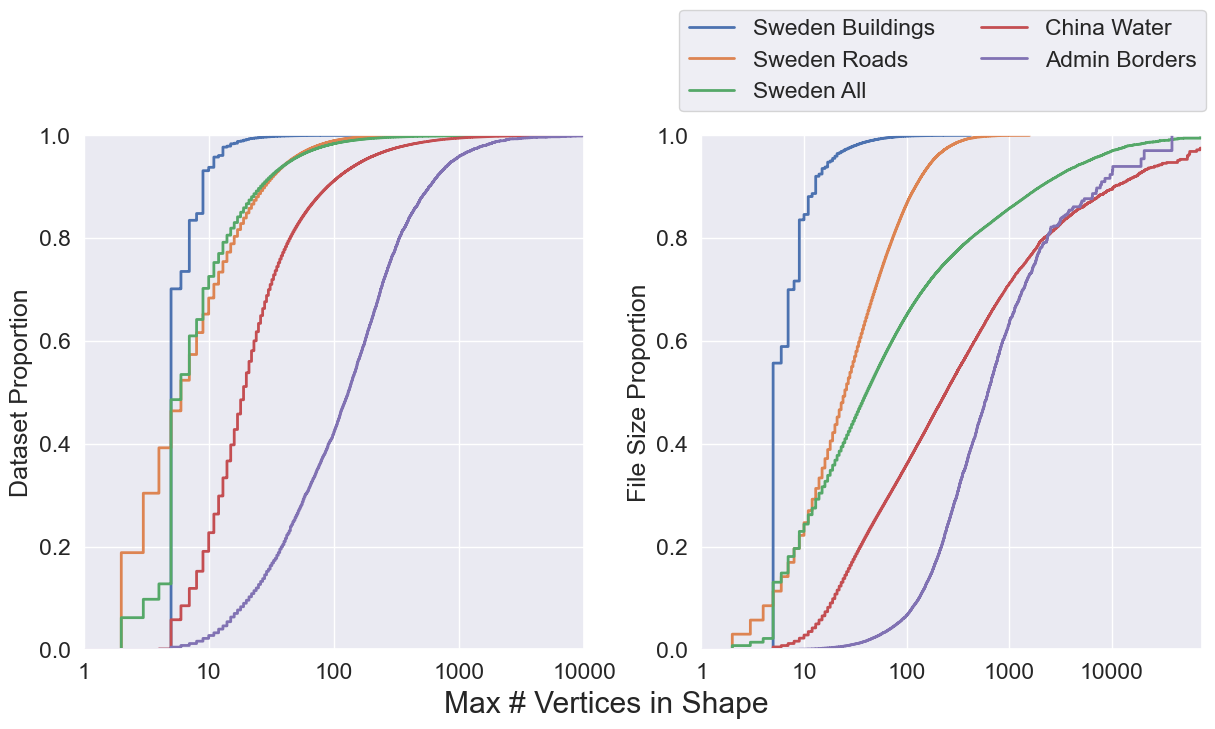

In [10]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()
fig.supxlabel("Max # Vertices in Shape")
#fig.suptitle("Datasets: # Vertices Distribution") # (Sweden All)

for f, v in all_vertex_cnts:
    if len(v) == 0:
        continue
    sns.ecdfplot(v, ax=axes[0], linewidth = 2)
    #sns.kdeplot(data=v, multiple="stack")
    #sns.kdeplot(v[:100], ax=axes[0], fill=True, common_norm=True, common_grid=True, cumulative=True)
    axes[0].set_ylim(0, 1)
    #sns.displot(v, kind="kde")
#ncol=4
legend = fig.legend(legends, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower right",
              borderaxespad=0, ncol=2, fancybox=True, shadow=False)
axes[0].set_xscale('log')
axes[0].set_xlim(1, 10000)
formatter = ScalarFormatter()
formatter.set_scientific(False) 
axes[0].xaxis.set_major_formatter(formatter)
#axes[0].set_xlabel("Max # Verticies in Shape")
axes[0].set_ylabel("Dataset Proportion")

# Weighted
for f, counts in all_vertex_cnts:
    if len(counts) == 0:
        continue
    weighted = [s for s in counts for _ in range(s)]
    sns.ecdfplot(weighted, ax=axes[1], linewidth = 2)
axes[1].set_xscale('log')
axes[1].set_xlim(1, 75000)
axes[1].xaxis.set_major_formatter(formatter)
axes[1].set_ylabel("File Size Proportion")

plt.savefig("plots/data_distrb_all.png", dpi=1000, bbox_inches='tight')
plt.savefig("plots/data_distrb_all.svg")
plt.show()